# YOLOV3 object detection

In this example, we'll demonstrate YOLOV3 object detection using OpenCV and the pretrained DarkNet model, provided by the author of YOLO. The model is trained using the COCO dataset.

Let's start with the imports:

In [1]:
import os.path

import cv2  # opencv import
import numpy as np
import requests

Next, we'll load the YOLO network configuration and pretrained weights from the author's gihub repo:

In [2]:
# Download YOLO net config file
# We'll it from the YOLO author's github repo
yolo_config = 'yolov3.cfg'
if not os.path.isfile(yolo_config):
    url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg'
    r = requests.get(url)
    with open(yolo_config, 'wb') as f:
        f.write(r.content)

# Download YOLO net weights
# We'll it from the YOLO author's website
yolo_weights = 'yolov3.weights'
if not os.path.isfile(yolo_weights):
    url = 'https://pjreddie.com/media/files/yolov3.weights'
    r = requests.get(url)
    with open(yolo_weights, 'wb') as f:
        f.write(r.content)

Then, we'll instantiate the model using OpenCV:

In [3]:
net = cv2.dnn.readNet(yolo_weights, yolo_config)

Next, we'll download and load the COCO class names, so we'll know what the algorithm output is:

In [4]:
# Download class names file
# Contains the names of the classes the network can detect
classes_file = 'coco.names'
if not os.path.isfile(classes_file):
    url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names'
    r = requests.get(url)
    with open(classes_file, 'wb') as f:
        f.write(r.content)

# load class names
with open(classes_file, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

We'll continue with loading the input image, where we want to detect the objects:

In [5]:
# Download object detection image
image_file = 'source_1.png'
if not os.path.isfile(image_file):
    url = "https://github.com/ivan-vasilev/advanced-deep-learning-with-python/blob/master/chapter04-detection-segmentation/source_1.png"
    r = requests.get(url)
    with open(image_file, 'wb') as f:
        f.write(r.content)

# read and normalize image
image = cv2.imread(image_file)
blob = cv2.dnn.blobFromImage(image, 1 / 255, (416, 416), (0, 0, 0), True, crop=False)

Next, we'll use `blob` as input to `net`, which will produce the bounding boxes and classes for each bounding box:

In [6]:
# set as input to the net
net.setInput(blob)

# get network output layers
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# inference
# the network outputs multiple lists of anchor boxes,
# one for each detected class
outs = net.forward(output_layers)

Then, we'll pre-process the network outputs and we'll apply non-max suppression over them to produce the final set of detected objects:

In [7]:
# extract bounding boxes
class_ids = list()
confidences = list()
boxes = list()

# iterate over all classes
for out in outs:
    # iterate over the anchor boxes for each class
    for detection in out:
        # bounding box
        center_x = int(detection[0] * image.shape[1])
        center_y = int(detection[1] * image.shape[0])
        w, h = int(detection[2] * image.shape[1]), int(detection[3] * image.shape[0])
        x, y = center_x - w // 2, center_y - h // 2
        boxes.append([x, y, w, h])

        # confidence
        confidences.append(float(detection[4]))

        # class
        class_ids.append(np.argmax(detection[5:]))

# non-max suppression
ids = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.75, nms_threshold=0.5)

Next, we'll plot each bounding box and class label over the input image:

In [8]:
# draw the bounding boxes on the image
colors = np.random.uniform(0, 255, size=(len(classes), 3))

# iterate over all boxes
for i in ids:
    i = i[0]
    x, y, w, h = boxes[i]
    class_id = class_ids[i]

    color = colors[class_id]

    cv2.rectangle(img=image,
                  pt1=(round(x), round(y)),
                  pt2=(round(x + w), round(y + h)),
                  color=color,
                  thickness=3)

    cv2.putText(img=image,
                text=f"{classes[class_id]}: {confidences[i]:.2f}",
                org=(x - 10, y - 10),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.8,
                color=color,
                thickness=2)

Finally, we'll display the result using `matplotlib` for it's integration with jupyter:

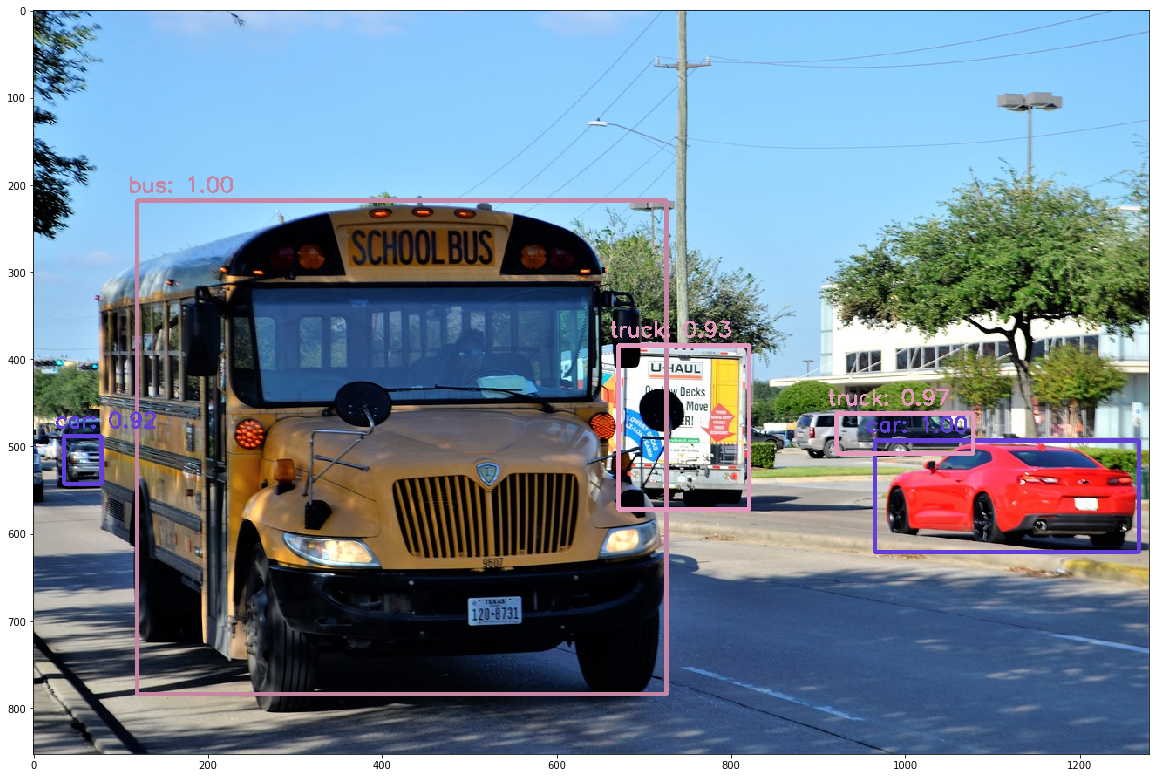

In [10]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))